In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [2]:
# Generate Data
mean1 = [0,0]
cov1 = [[1,0],[0,1]]
dataSize1 = 20
gauss1 = np.random.multivariate_normal(mean1, cov1, dataSize1)
labels1 = np.full(dataSize1, -1, dtype=np.float64)

mean2 = [3,3]
cov2 = [[1,0],[0,1]]
dataSize2 = 20
gauss2 = np.random.multivariate_normal(mean2, cov2, dataSize2)
labels2 = np.full(dataSize2, 1, dtype=np.float64)

dataset = np.concatenate((gauss1, gauss2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)

data_train, data_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.20, random_state=42)

In [3]:
class HyperPlane:
    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    def calculatePointLabel(self, x):
        return 1 if (np.dot(self.w, x) + self.b) > 0 else -1

In [4]:
class SVMModel:
    
    def __init__(self):
        pass
    
    def train(self, trainData, trainLabels):
        start_time = time.time()
        self.hyperplane = CalculateHyperplane(trainData, trainLabels)
        return time.time() - start_time
        
    def test(self, testData, testLabels):
        if self.hyperplane is None:
            raise RunTimeError('You must train the model before testing')
            
        start_time = time.time()
        predictions = list(map(lambda testDataPoint: SVM(self.hyperplane, testDataPoint), testData))
        accuracy = accuracy_score(testLabels.tolist(), predictions)
        timing = time.time() - start_time
        return accuracy, timing

$$\begin{eqnarray}
\min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\
\textrm{s.t.}\quad Gx \preceq h \\\
\textrm{and}\quad Ax = b
\end{eqnarray}
$$

$$\begin{eqnarray}
\min_{\alpha}\frac{1}{2} \alpha^{T}K\alpha - 1^{T}\alpha \nonumber \\\
\textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\
\textrm{and}\quad y^{T}\alpha = 0
\end{eqnarray}$$

In [5]:
def CalculateHyperplane(trainData, trainLabels):
    x = trainData
    y = trainLabels
    
    NUM = x.shape[0]
    DIM = x.shape[1]
    K = y[:, None] * x
    K = np.dot(K, K.T)
   
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    # get weights
    w = np.sum(alphas * y[:, None] * x, axis = 0)
    # get bias
    cond = (alphas > 1e-4).reshape(-1)
    b = y[cond] - np.dot(x[cond], w)
    bias = b[0]
    return HyperPlane(w, bias)

In [6]:
def SVM(hyperplane, datapoint):
    label = hyperplane.calculatePointLabel(datapoint)
    return label

In [7]:
svmModel = SVMModel()
print(svmModel.train(data_train, labels_train))
print(svmModel.test(data_test, labels_test))

0.010006427764892578
(1.0, 0.0)


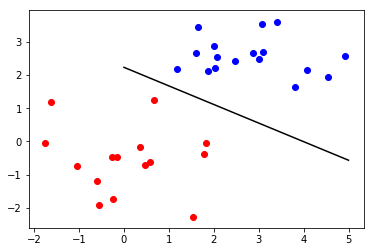

In [8]:
fig, ax = plt.subplots()
COLORS = ['red', 'blue']
labels = np.unique(labels_train)
for li in range(len(labels)):
    x_sub = data_train[labels_train == labels[li]]
    ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    
w = svmModel.hyperplane.w
b = svmModel.hyperplane.b
slope = -w[0] / w[1]
intercept = -b / w[1]
x = np.arange(0, 6)
ax.plot(x, x * slope + intercept, 'k-')

In [9]:
#     print(np.shape(K))
#     print(np.shape(P))
#     print(np.shape(q))
#     print(np.shape(G))
#     print(np.shape(h))
#     print(np.shape(A))
#     print(np.shape(b))